In [ ]:
###############################
#Version quick test of crossvalidsation
###############################

#!pip install shap

# Basics
import numpy as np
import pandas as pd
from pathlib import Path
from google.colab import files
from google.colab import drive

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from operator import itemgetter
#from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import RandomizedSearchCV
import lightgbm
import shap

#GPU
import tensorflow as tf
#tf.test.gpu_device_name()

#Feature selection methods
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE # Recursive feature elimination
from sklearn.feature_selection import RFECV # with crossvalidation
from sklearn.svm import SVC
#from genetic_selection import GeneticSelectionCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel


#Classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#Evaluation
import time
from datetime import datetime, timedelta
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics.pairwise import normalize


#Visualization
%matplotlib inline
from IPython.display import HTML, display
import seaborn as sns
import matplotlib.pyplot as plt
###############################################################################
#Initilaization
###############################################################################
#OS
#Path.home()
#uploaded = files.upload()

#print all rows
pd.set_option('display.max_rows', 20)

#################################################################################
#Staging
#################################################################################
#Mount Google drive
#drive.mount('/content/drive')

 #Import files from Drive
#!cp "/content/drive/My Drive/PHD/S10/Results/S1_AED_Fracture_v0_fe_total_selected_features.csv" "S1_AED_Fracture_v0_fe_total_selected_features.csv"
#!ls

def print_border(type, length=70):
  border = ''
  for i in range(length+1):
    border=border+type
  print (border)

def listToString(s):
    # initialize an empty string
    str1 = ""
    # traverse in the string
    for ele in s:
        str1 += ele+','
    # return string
    return str1

def SMOTE(y_train, ratio):
  print('Performing SMOTE')

def make_csv_df(dataset,y, sep, split,test_size, featuregroup, dataset_type):
    X_train_pd=[]
    X_test_pd=[]
    y_train_pd=[]
    y_test_pd=[]
    #OrgConcept=[51131148, 51126540,51136012]
    df = pd.read_csv(dataset,sep=sep, low_memory = False)
    rows =len(df)
    print ('Selected dataset type and feature group:', dataset_type,'and' ,featuregroup)
    df=df.head(rows)
    if dataset_type=='EVENT':
      print ('chosen EVENT')
      if ('PK' in df.columns):
        df=df.drop(columns=['PK'])
      if (featuregroup in (['ORG','IDEATION' ,'FE-GEN'])):
        df=df[df['CREATION_PHASE']==featuregroup]
        print(featuregroup, 'chosen')
      if (featuregroup=='ORGIDEA'):
        print('ORGIDEA chosen')
        df=df[df['CREATION_PHASE'].isin(['ORG','IDEATION'])]
      if (featuregroup=='ORGFE'):
        print('ORGFE chosen')
        df=df[df['CREATION_PHASE'].isin(['ORG','FE-GEN'])]
      display(df.groupby(['CREATION_PHASE', 'CONCEPT_ID'])['PID'].count() )
      print('Unique F-group and unique patients:')
      display(df[['CREATION_PHASE', 'PID']].drop_duplicates().groupby(['CREATION_PHASE'])['PID'].count() )
      df=df.drop(columns=['CREATION_PHASE'])
      df=df.drop(columns=['CONCEPT_ID'])
    if dataset_type=='MLR':
      print ('chosen MLR')
      if ('PK' in df.columns):
        df=df.drop(columns=['PK'])
      if (featuregroup=='ORG'):
        df=df[org_list+y]
        print('ORG chosen')
      if (featuregroup=='IDEATION'):
        df=df[idea_list+y]
        print('IDEATION chosen')
      if (featuregroup=='FE-GEN'):
        df=df.drop(columns=org_list+idea_list)
        print('FE-GEN chosen')
      if (featuregroup=='ORGIDEA'):
        df= df[org_list+idea_list+y]
        print('ORGIDEA chosen')
      if (featuregroup=='ORGFE'):
        df=df.drop(columns=idea_list)
        print('ORGFE chosen')

#Creating target dataset
    if verbose:
      print('Dropping target variable')
    df[y[0]].dropna()
    df[y[0]] = df[y[0]].astype(int)
    y_df=df[y[0]]

    #Minor class ratio
    if verbose:
      print ('Type and shape of y_pd',type(y_df), y_df.shape)
      print ('y_df.value_counts(normalize=True)',y_df.value_counts(normalize=True))
    minor_class_ratio=y_df.value_counts(normalize=True)[0].min()
    print('The minority rate is: ', minor_class_ratio) 

    X_df=df.drop(columns=[y[0]])
    #Replacing NaN with meanvalues
    if (imp_mean):
      X_df=X_df.fillna(X_df.mean())
      y_df=y_df.fillna(y_df.mean())
    
    #Drop all NaN /zero columns and convert to integer
    X_df.dropna(how='all', axis=1, inplace=True)

    #Summary of dataset
    X_var=X_df.columns.values
    print ("Imported number of rows: ", rows,"of",rows, "from dataset:", dataset)
    print ('The dataset has based on featuregroup and dataset type selected:',len(X_var), 'describing features and',len(y), 'dependent variabel:')
    print ('The describing features are: \n',X_var)
    print ('The dependent variable is:',y[0])

    #Splitting into train and test dataset
    if (split):
      X_train, X_test, y_train_list, y_test_list = train_test_split(X_df, y_df, test_size=test_size, random_state=8675309)
    y_test=pd.DataFrame(y_test_list)
    y_train=pd.DataFrame(y_train_list)
    for dataset in (X_df, X_train, X_test, y_train, y_test):
      print ('Size of: ',dataset, ' end create dataset, ', dataset.shape)

    return (dataset_type, X_df, y_df, X_train, X_test, y_train, y_test,minor_class_ratio)

def dfNorm(df, type):
    scaler = preprocessing.MinMaxScaler()
    columns=sorted(df)
    df=pd.DataFrame(scaler.fit_transform(pd.DataFrame(df)))
    if (type=='X'):
      df.columns=columns
    return (df)

def var_typing (df):
    i = 0
    df['f_code']='-1'
    for i in range (len(df)) :
      feature=df['feature'].iloc[i]
      if (feature[0:1] =='X'):
        feature_code = 'ORG'
      else:
       feature_code = 'FE'
      df['f_code'].iloc[i]=feature_code
      i+=1

def actual_time():
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S")
  return current_time

def time_diff(starttime, endtime):
  if starttime == 0:
    tmdelta=actual_time()
  else: 
    period=round(endtime-starttime)
    tmdelta= str(timedelta(seconds = period))
  return tmdelta

def VarianceThreshold_FS(X_train,n):
    threshold = 0
    print ('Varianace threshold started with n:', n)
    FS_VT=VarianceThreshold(threshold=threshold)
    X_train_VT=FS_VT.fit_transform(X_train)
    print ('Size of Variance threshold before masking and type:',X_train_VT.shape)
    X_VT_variance=FS_VT.variances_
    drop_columns=X_VT_variance.argsort()[:-n]
    sorted_var=np.sort(FS_VT.variances_)
    sorted_var=sorted_var[sorted_var.argsort()[-n:]]
    X_VT_mask=FS_VT.get_support()

    for i in range(len(drop_columns)):
      index=drop_columns[i]
      X_VT_mask[index] = False

    VT_selected_features = X_train.loc[:, X_VT_mask]
    print ('Shape of dataset after feature selection with variance threshold:', VT_selected_features.shape)
    return VT_selected_features

def KBestMutual(X_train,y_train,n):
    print ('KBEstMut started with n:', n)
    FS_KBMutual=SelectKBest(mutual_info_classif, k=n)
    X_KBMutual=FS_KBMutual.fit_transform(X_train, y_train)
    X_KBMutual_mask=FS_KBMutual.get_support()
    kbestN_selected_features = X_train.loc[:, X_KBMutual_mask]
    print ('Shape of dataset after feature selection with KBest-Mutual:', kbestN_selected_features.shape)
    return kbestN_selected_features

def RFE_FS(X_train,y_train,n):
    print ('RFE started with n:', n)
    estimator =DecisionTreeClassifier()
    FS_RFE = RFE(estimator=estimator, n_features_to_select =n, step=1, verbose=0)
    X_RFE=FS_RFE.fit(X_train, y_train)
    X_RFE_mask=FS_RFE.get_support()
    RFE_selected_features = X_train.loc[:, X_RFE_mask]
    print ('Shape of dataset after feature selection with Recursive feature elimination (RFE):', RFE_selected_features.shape)
    return RFE_selected_features

def RFECV_FS(X_train,y_train,n):
    print ('RFECV started with n:', n)
    estimator =DecisionTreeClassifier()
    FS_RFECV = RFECV(estimator=estimator, min_features_to_select=n, step=1, verbose=0)
    X_RFECV=FS_RFECV.fit(X_train, y_train)
    X_RFECV_mask=FS_RFECV.get_support()
    RFECV_selected_features = X_train.loc[:, X_RFECV_mask]
    print ('Shape of dataset after feature selection with Recursive feature elimination CV (RFECV):', RFECV_selected_features.shape)
    return RFECV_selected_features

def VT_RFE(X_train, y_train, pre_filter_n_features, end_n_features):
  print('Calling VT with n:',pre_filter_n_features ,' for initial filtering')
  VT_selcted_features= VarianceThreshold_FS(X_train,pre_filter_n_features)
  print ('Starting RFE')
  VT_RFE_selected_features = RFE_FS(VT_selcted_features,y_train, end_n_features )
  return VT_RFE_selected_features

def SModelLassoCV(X_train, y_train,n):
    estimator=LassoCV(cv=5)
    iterations=100
    FS_X =X_train
    threshold=-np.inf
    FS_SModelLasso=SelectFromModel(estimator, max_features=n, threshold=threshold)   
    X_Lasso=FS_SModelLasso.fit(X_train, y_train)
    FS_scores = X_Lasso.estimator_.coef_
    if verbose:
      print('Ranking of features', X_Lasso.n_features_in_)
      print('Rank score of features', X_Lasso.estimator_.coef_)
      print ('Filetype for scores: ', type(X_Lasso.estimator_.coef_))


    X_Lasso_mask=FS_SModelLasso.get_support()
    print ('LassoCV mask', X_Lasso_mask)
    SModelLassoCV_selected_features = X_train.loc[:, X_Lasso_mask]
    #X_SModelLasso_test_df = FS_X_test.loc[:, X_Lasso_mask]
    print ('Dataframe with Lasso (model selection) for n=',n,'best features')
    return  SModelLassoCV_selected_features

def feature_selection (y, dataset, dataset_type, featuregroup_list,selection_methods,  normalization=0, balancing=0):
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    '''
    print_border('#', 50)
    #print('Number of crossvalidations', cv_iter) 
    print ('Starting feature selection. Dataset to be used: ', dataset, ', used featuregroups: ', featuregroup_list)
    #print ('Used featuregroup:', featuregroup_list)
    print_border('#', 50)
    results = []
    names = []
    global selected_features
    local_run_report_df= pd.DataFrame(columns=RUN_REPORT_COLUMNS)
    
    ## Loop over featuregroups in dataset
    for feature_group in featuregroup_list:
        dataset_type, X_pd, y_pd, X_train, X_test, y_train, y_test, minor_class_ratio = make_csv_df(dataset_import, y, ';', split, test_size, feature_group, dataset_type)

        print ('Normalization', Normalization)
        X_train_init=X_train
        X_test_init=X_test
        y_train_init=y_train
        y_test_init= y_test
        X_pd_init = X_pd

        for k in Normalization:
          if (k=='Yes'):
            Norm=k
            print('Normalization of df performed')
            y_train_norm=dfNorm(y_train_init, 'y')
            #y_test=dfNorm(y_test_init,'y')
            X_train_norm=dfNorm(X_train_init, 'X')
            #X_test_norm=dfNorm(X_test_init, 'X')
            #X_pd_norm=dfNorm(X_pd_init, 'X')
          else:
            Norm='No'
            print('No normalization of df performed')
            y_train_norm=y_train_init
            #y_test=y_test_init
            X_train_norm=X_train_init
            #X_test_norm=X_test_init
            #X_pd_norm=X_pd_init
          #########################################
          #Feature selection
          ##########################################
          for FS_name, method in selection_methods:
              print ('Selected FS-method:', FS_name)
              print ('Size of dataset before FS-method',X_train_norm.shape )
              if FS_name == 'NO_FS':
                   selected_features_method = X_train_norm
              elif FS_name == 'VT_RFE':
                   n_first_filtering = 15
                   selected_features_method=eval(method+'( X_train_norm, y_train_norm,n_first_filtering, n)')
              else:
                  selected_features_method=eval(method+'( X_train_norm, y_train_norm,n)')
              
              inner_selected_features=pd.DataFrame(sorted(selected_features_method), columns=['feature'])
              inner_selected_features.insert(0,'Dataset',dataset )
              inner_selected_features.insert(1,'Dataset type',dataset_type )
              inner_selected_features.insert(2,'FS_method',method )
              inner_selected_features.insert(3,'Norm',Norm )
              inner_selected_features.insert(4,'Featuregroup',feature_group )
              #selected_features.append(inner_selected_features)
              selected_features=pd.concat([selected_features, inner_selected_features], ignore_index=True)
              if verbose:
                print('Type of variables selected_features: ',type(selected_features),' and inner_selected_features:', type(inner_selected_features))
                #print ('Fel! Selected features for this run df:',selected_features )
                #print ('Rätt ? Inner selected features df:',inner_selected_features )
              print ('Norm before modeling', Norm)
              y_train_arr=np.array(y_train_norm).astype('int32').flatten()
              for i in (selected_features_method, y_train_arr):
                  print ('Feature selectio n ready: Shape of selected_features_method, y_train_arr:', y_train_arr.shape)
              #Evaluation of ml-models with selected features 
              #model_evaluation (dataset, feature_group, dataset_type, X_train_selected, y_train, X_test, y_test, models, minor_class_ratio, cv_outer_n, cv_inner_n, Norm, FS_name, balancing=0)
              y_pred= 'tomt'
    return inner_selected_features, X_train, X_test, y_train, y_test, minor_class_ratio

def selected_features_to_list (selected_features):
    dataset_value_list = selected_features.Dataset.unique().tolist()
    FS_method_value_list= selected_features.FS_method.unique().tolist()
    norm_values_list=selected_features.Norm.unique().tolist()
    featuregroup_value_list= selected_features.Featuregroup.unique().tolist()

    selected_features_unique=pd.DataFrame()
    selected_features_unique['feature_list_list']= ''
    selected_features_unique['selected_features_char']=''


    temp_df = selected_features.drop(['feature'], axis=1)
    selected_features_unique = temp_df.drop_duplicates(keep='first')
    print ('Unique combinations of feature groups',selected_features_unique)
    print('Lists with groups to iterate over' ,norm_values_list,dataset_value_list,FS_method_value_list, featuregroup_value_list )
    print_border('#', 100)

    for dataset in dataset_value_list:
      for fs_method in FS_method_value_list:
        for norm in norm_values_list:
          for featuregroup in featuregroup_value_list:
              c1=selected_features['Dataset']==dataset
              c2=selected_features['FS_method']==fs_method
              c3=selected_features['Norm']==norm
              c4=selected_features['Featuregroup']==featuregroup
              conditions=c1 & c2 & c3 & c4
              c1_uniq=selected_features_unique['Dataset']==dataset
              c2_uniq=selected_features_unique['FS_method']==fs_method
              c3_uniq=selected_features_unique['Norm']==norm
              c4_uniq=selected_features_unique['Featuregroup']==featuregroup
              conditions_uniq = c1_uniq & c2_uniq & c3_uniq & c4_uniq
              if verbose:
                  print ('Conditions: ',conditions)
                  print ('Conditions for unique dataset', conditions_uniq)
              feature_list=selected_features.loc[c1 & c2 & c3 & c4].feature.unique().tolist()
              print_border('#', 50)

              print ('Feature list: ', feature_list, ', Dataset: ', dataset, ', FS_method: ', fs_method, ', Norm: ', norm, 'Featuregroup: ',featuregroup )
              selected_features_unique.loc[conditions_uniq,'selected_features_char'] = listToString(feature_list)
              row_index=selected_features_unique.loc[conditions_uniq].index.values
              print ('row_index', row_index, type(row_index), len(row_index))

              selected_features_unique.at[row_index[0], 'feature_list_list'] = np.array(feature_list)
              ####list gave this error = Must have equal len keys and value when setting with an iterable
    print_border('#', 100)
    selected_features_unique = selected_features_unique.reset_index()  # make sure indexes pair with number of rows
    print ('Selected features for ecah data subset, each row should be evaluated by classification evaluation ')
    display (selected_features_unique)
    return  selected_features_unique

    
def model_evaluatio_old (dataset,feature_group, dataset_type, X_train, y_train, X_test, y_test, models, minor_class_ratio, cv_outer_n,cv_inner_n,Norm,FS_name, balancing=0):
    print_border('#', 50)
    Modelrun=0
    if ( (minor_class_ratio < 0.3) and balancing):
      print ('Performing SMOTE on train X with ratio 1:2')
    else: 
      print('Dataset well balanced, no need for SMOTE')
    print_border('#', 50)
    print('Modelrun#',Modelrun,', Starting:',time_diff(starttime, time.time()),', Dataset:', dataset, ', Datseset type:',dataset_type, 'Featuregroup:',feature_group,', CV outer#',cv_outer_n,', CV inner#',cv_inner_n,', Normalization:', Norm,', FS-Method:', FS_name,', Class-Model:', name,'-' ,model)
    for name, model in models:
        cv_outer = KFold(n_splits=cv_outer_n, shuffle=True, random_state=1)
        # enumerate splits
        outer_results = list()
        for train_ix_val, test_ix_val in cv_outer.split(X_train):
          # split data
          X_train_val, X_test_val = X_train[train_ix_val, :], X_train[test_ix_val, :]
          y_train_val, y_test_val = y[train_ix_val], y[test_ix_val]
          # configure the cross-validation procedure
          cv_inner = KFold(n_splits=cv_inner_n, shuffle=True, random_state=1)
          # define search space
          space = dict()
          if (name == 'RF'):
            space['n_estimators'] = [10, 100, 500]
            space[ 'max_depth']= [10, 50, 100, None]
            space[ 'min_samples_leaf']= [1, 2, 4]
            space['max_features'] = [5]
          elif (name == 'LogReg'):
            space['penalty'] = ['l1', 'l2']
            space[ 'C']= [np.logspace(-5, 4, 10)]
          # define search
          search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
          # execute search
          result = search.fit(X_train_val, y_train_val)
          # get the best performing model fit on the whole training set
          best_model = result.best_estimator_
          # evaluate model on the hold out dataset
          yhat = best_model.predict(X_test)
          # evaluate the model
          test_acc = accuracy_score(y_test, yhat)
          test_auroc = roc_auc_score(y_test, yhat)
          # store the result
          outer_results.append(test_acc)
          outer_results.append(test_auroc)
          print ('Outer result', outer_results)
      #Nested cross validation with SMOTE
      #Balancing with SMOTE 


Documentation
mrMR:   https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

Scikit-rebate:   https://pythonrepo.com/repo/EpistasisLab-scikit-rebate-python-feature-engineering

Normaization of df
https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn

Embedded model by model selection https://www.datasklr.com/ols-least-squares-regression/variable-selection

SHAP Feature Selection
https://github.com/manuel-calzolari/shapicant

In [ ]:
########################################
#Initialization of experiment
########################################
#Used dataset
dataset='S10_Dataset_P1'
project=dataset[12:14]
dataset_import=dataset+'.csv'
print('Dataset_name:', dataset_import, ' and project ID:', project)
print_border('-')
environment = 'colab'

#Import RAW data (csv-files) from Drive
if environment == 'colab':
  !cp "/content/drive/MyDrive/PHD/S10/dataset/S10_Dataset_P1.csv" S10_Dataset_P1.csv
  !cp "/content/drive/MyDrive/PHD/S10/dataset/S10_Dataset_P1_1000.csv" S10_Dataset_P1_1000.csv
# elif environment == 'local'


#Import locally on computer
#dataset_import='C:/Users/olbjaa/Documents/PHD/Dataset/'+dataset_import
#dataset='C:/Users/olbjaa/Documents/PHD/Dataset/'+dataset_import

#Init values
#featuregroup_list = ['ORG', 'FE-GEN', 'ORGFE', 'ORGIDEA']
dataset_type = 'MLR'
featuregroup_list = ['ORGFE']
print ('Dataset type is:',dataset_type,' and featurgroups are:', featuregroup_list)
print_border('-')

result_df = []
#selected_features = []

imp_mean=1
split=True
test_size=0.3
FS_scores = []
if project== 'P1':
    org_list = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11"]
elif project== 'P2':
    org_list = ["X1"]
idea_list = []
y=['Y1']
print('The list of ORG-featrures are:', org_list, ' and IDEA-list:', idea_list)
print_border('-')


balancing = True
#Numbers of features to select
n=5
reporting = False
verbose=False
#cv_iter = 2
cv_outer_n=10
cv_inner_n=3
Normalization=['Yes', 'No']
#Normalization=['No']
#print ('Dataset to be used:', dataset)
#print ('Used featuregroup:', featuregroup_list)
#print ('Number of cv:', cv_iter)
#print ('Used normalization:', Normalization)



selection_methods = [
('NO_FS', 'No Feature selection'),
('KBestMut', 'KBestMutual'),
('SModLassoCV', 'SModelLassoCV'),
('VT_RFE','VT_RFE')
]

#selection_methods = [('SModLassoCV', 'SModelLassoCV')]

print('Total feature selection methods to be used:', len(selection_methods))
for j in range (len(selection_methods)):
  print (selection_methods[j][0])

models = [( 'LogReg', LogisticRegression(max_iter=1000,solver='liblinear' ) ), 
('RF', RandomForestClassifier()),
#('KNN', KNeighborsClassifier()),
#('SVM', SVC()), 
('GNB', GaussianNB()),
('XGB', XGBClassifier()),
('ANN', MLPClassifier())
#('ANN-Small',MLPClassifier(hidden_layer_sizes=(15,10,5))),
#('ANN-Large',MLPClassifier(hidden_layer_sizes=(150,100,50)))
]

#models = [( 'LogReg', LogisticRegression(max_iter=100,solver='liblinear' ) )]
print_border('-')
print('Total classification models to be used:', len(models))
for j in range (len(models)):
  print (models[j][0])

total_model_iterations=len(selection_methods)*len(featuregroup_list)*len(Normalization)*cv_outer_n*len(models)
print('Number of total model iterations', total_model_iterations)
# 4*2*2*10*5 = 800 iterations?



In [ ]:
########################################################################
#Run experiment v2
########################################################################

print ('USED GPU:', tf.test.gpu_device_name())
#RUN_REPORT_COLUMNS=['Model#','CV#','Dataset','Dataset type','Normalizations','FS_method','Featuregroups','Class_modell','Test_accuracy', 'Test_ROC_AUC','Test_ROC_AUC_MV' ]

#RUN_REPORT_COLUMNS=['Dataset','Dataset type','Normalizations','FS_method','Featuregroup','Balancing_needed','Total_model_run#' ,'Classification_modell','CV_outer','CV-inner','Model_outer_iteration#','Best_model_from_ncv' ,'Test_accuracy', 'Test_AUCROC', 'Test_AUCROC_MV', 'Test_F1', 'Test_Prec', 'Test_Recall','Test_Sens','Test_Spec', 'Test_accuracy_ncv', 'Test_AUCROC_ncv',  'Test_F1_ncv', 'Test_Prec_ncv', 'Test_Recall_ncv','Test_Sens_ncv','Test_Spe_ncvc'  ]
RUN_REPORT_COLUMNS=['Dataset','Dataset type','Normalizations','FS_method','Featuregroup','Balancing_needed','Total_model_run#' ,'Classification_modell','CV_outer','CV-inner','Model_outer_iteration#','Best_model_from_ncv' ]
total_run_report_df=pd.DataFrame(columns=RUN_REPORT_COLUMNS)
selected_features=pd.DataFrame( columns=['feature'])


starttime=time.time()
#starttime=time_diff(0,0)
print('Execution started at:',time_diff(0,starttime))

print('\n')
print_border('#', 50)
#1. Create dataset for each featuregroup and FS method (ml_pipeline calls create dataset and model_eval)

inner_selected_features, X_train, X_test, y_train, y_test, minor_class_ratio = feature_selection (y, dataset,dataset_type, featuregroup_list, selection_methods, normalization=0, balancing=0)
selected_features_list = selected_features_to_list (selected_features)


#model_eval (X_train, y_train, X_test, y_test, models, minor_class_ratio, cv_outer_n, cv_inner_n, Norm, FS_name, balancing=0)
#exp_selected_f, y_pred, result_df, local_run_report_df =aKDFE_eval_PS(f_selected,y ,Normalization,  dataset,featuregroup_list, cv_iter)
#print ('Result after classification for FS-method:',FS, '-- Normalization:',Norm, '-- Dataset:',dataset, end = "")
#display (exp_result)


In [ ]:
#Quick fit and cross validation test with measure  
from sklearn.model_selection import cross_val_score

# Create  dataset
X_test.shape
FS_list=selected_features_list.loc[0,'feature_list_list']
type(X_train), type(X_test)
X_df=pd.concat([X_train, X_test])
y_df0=pd.concat([y_train, y_test])
y_df=y_df0.values.ravel()
print (X_df.shape, X_train.shape, X_test.shape)
print (y_df0.shape, y_df.shape, y_train.shape, y_test.shape)


#Classifiers (Norm = No, FS = NO_FS from experiment S10 P1)
LogReg_clf = LogisticRegression(C=0.31622776601683794, max_iter=1000, penalty='l1', solver='liblinear', verbose=2)
RF_clf= RandomForestClassifier(max_depth=10, max_features=5,  verbose = 1)
ANN_clf=MLPClassifier(alpha=0.05, hidden_layer_sizes=(15, 10, 5))
XGB_clf=XGBClassifier(gamma=0.5, subsample=0.75, verbose = 2)
GNB_clf=GaussianNB()

#test_model_list=[('RF',RF_clf) ,('ANN', ANN_clf),('LogReg',LogReg_clf),('XGB', XGB_clf),('GNB',GNB_clf) ]
test_model_list=[('RF',RF_clf) ,('ANN', ANN_clf),('XGB', XGB_clf),('GNB',GNB_clf) ]
score_df=pd.DataFrame(columns=['model', 'score'])
print (type(score_df))

#Model evaluation
for name, test_model in test_model_list:
  score_name=name+'_score'
  print_border('#', 100)
  print ('Crossvalidation of:', name, ' with classifier model:', test_model, 'with score name:', score_name)
  print_border('#', 100)
  print (type(score_df))
  score_value = cross_val_score(test_model, X_df, y_df,cv=5, verbose=1 )
  row=len(score_df)
  score_df.at[row,'score']=score_value
  score_df.at[row,'model']=name
  print ('Scoring dataframe size:', score_df.shape)

display (score_df)



Utdata för streaming har trunkerats till de sista 5000 raderna.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using ba

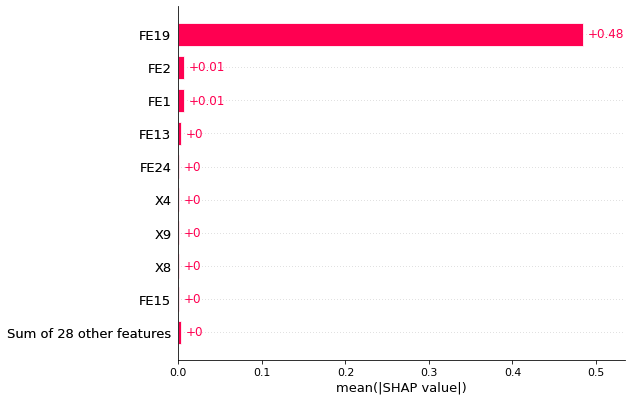

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


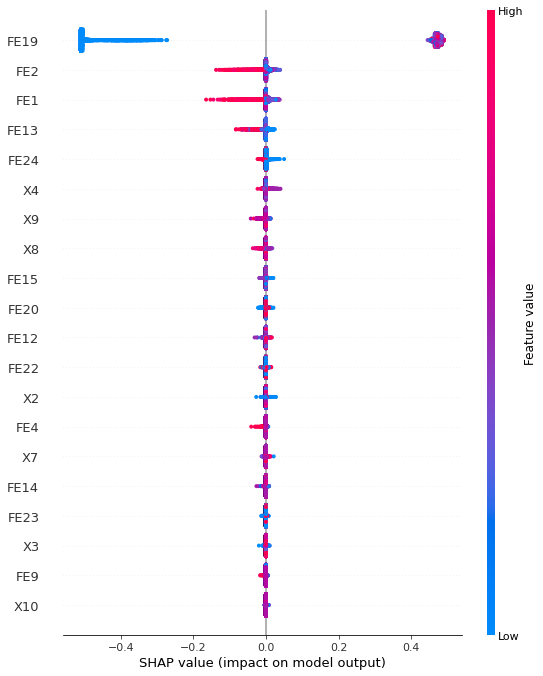

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


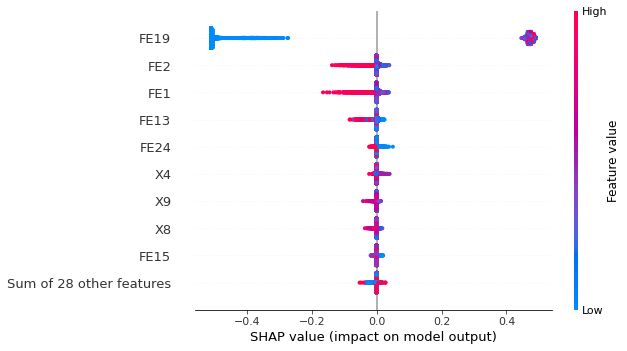

In [10]:
#!pip install shap
#import shap


# Shap explainer
################
#create a model
# Prepares a default instance of the random forest regressor
model = RandomForestClassifier(max_depth=10, max_features=5)
# Fits the model on the data
model.fit(X_train, y_train)

# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

shap.plots.bar(shap_values)
shap.summary_plot(shap_values)
shap.plots.beeswarm(shap_values)


In [9]:
X_train.shape, y_train.shape, X_test.shape
  

((18788, 37), (18788, 1), (8052, 37))

In [ ]:
def model_evaluation (X_train, y_train, X_test, y_test, selected_features_list, models, minor_class_ratio, cv_outer_n,cv_inner_n, balancing=0):
    print_border('#', 50)
    Total_model_run=0
    performed_selected_datasets = 0
    global total_run_report_df
    total_class_report_df=pd.DataFrame(columns=RUN_REPORT_COLUMNS)
    for index, row in  selected_features_list.iterrows():
        if ( (minor_class_ratio < 0.3) and balancing):
          print ('Performing SMOTE on train X with ratio 1:2')
        else: 
          print('Dataset well balanced, no need for SMOTE')
        print_border('#', 50)
        number_of_datasets=len(selected_features_list)
        dataset = row[1]
        dataset_type =row[2]
        FS_name=row[3]
        Norm=row[4]
        feature_group =row[5]
        selected_features=row[7].tolist()
        print ('Variabel test::', 'Dataset:', dataset, ', Datseset type:',dataset_type, ', Featuregroup:',feature_group,', Normalization:', Norm ,', FS-Method:', FS_name,', selected_features:', selected_features   )
        print_border('-', 20)
        print ('Size of X-train before: ', X_train.shape)
        print ('Size of X-test before: ', X_test.shape)
        X_train_selected=X_train[selected_features]
        X_test_selected=X_test[selected_features]
        print ('Size of X-train after selection: ', X_train_selected.shape)
        print ('Size of X-test after selection: ', X_test_selected.shape)
        print_border('-', 20)
        performed_selected_datasets+=1
        
        for name, model in models:
            print('Total feature selected dataset#',number_of_datasets,', Starting:',time_diff(starttime, time.time()),', Dataset:', dataset, ', Datseset type:',dataset_type, 'Featuregroup:',feature_group,', CV outer#',cv_outer_n,', CV inner#',cv_inner_n,', Normalization:', Norm,', FS-Method:', FS_name,', Class-Model:', name,'-' ,model)
            cv_outer = KFold(n_splits=cv_outer_n, shuffle=True, random_state=1)
            model_outer_iteration_number=0
            print('Feature selected dataset#',performed_selected_datasets, 'of total:',number_of_datasets, 'Starting model evaluation with: ', cv_outer_n, 'outer iterations and ', cv_inner_n, ' inner iteration', ' at:', time_diff(starttime, time.time()))
            print_border('-', 20)
            # enumerate splits
            outer_results = list()
    ##Ref to nested cross validation https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
            for train_ix_val, test_ix_val in cv_outer.split(X_train_selected):
              Total_model_run+=1
              model_outer_iteration_number+=1
              print ('Feature selected dataset#',performed_selected_datasets, 'of total:',number_of_datasets, 'Model outer iteration number: ', model_outer_iteration_number, ' of:', cv_outer_n,' for model: ', model, ' of', len(models) ,' at:', time_diff(starttime, time.time()) )
              print_border('-', 20)

              X_train_ncv = X_train_selected.iloc[train_ix_val] 
              X_test_ncv = X_train_selected.iloc[test_ix_val]
              y_train_ncv = y_train.iloc[train_ix_val]
              y_test_ncv =  y_train.iloc[test_ix_val]
              print ('Size of validation datset after splitting :: ', 'X_train_val:',X_train_ncv.shape,'X_test_val:',X_test_ncv.shape, 'y_train_val:',y_train_ncv.shape,  'y_test_val:',y_test_ncv.shape )
              # configure the cross-validation procedure
              cv_inner = KFold(n_splits=cv_inner_n, shuffle=True, random_state=1)
              # define search space
              space = dict()
              if (name == 'RF'):
                space['n_estimators'] = [10, 100, 500]
                space[ 'max_depth']= [10, 50, 100, None]
                space[ 'min_samples_leaf']= [1, 2, 4]
                space['max_features'] = [5]
              elif (name == 'LogReg'):
                space['penalty'] = ['l1', 'l2']
                space['C']= np.logspace(-5, 4, 5).tolist()
              elif (name=='GNB'):
                space['var_smoothing'] = np.logspace(0,-9, num=10)
              elif (name=='XGB'):
                space['gamma'] = [0.5, 1, 2, 5]
                space['subsample']= [0.75, 1.0]
                space['max_depth']= [3, 4, 5]
              elif (name=='ANN'):
                space['hidden_layer_sizes']=[(15,10,5),(150, 100, 50)]
                space['alpha']=[0.0001, 0.05]
              # define search
              print_border('#', 50)
              print ('Used model:',model, ', space:', space, ', model-name:', name )
              search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True, error_score='raise', verbose=0)
              print_border('-', 20)
              # execute search
              result = search.fit(X_train_ncv, y_train_ncv.values.ravel())
              # get the best performing model fit on the whole training set
              best_model = result.best_estimator_
              print ('Nested crossvalidation gave the following best paramteter: ',best_model ,' for classification model',model ,' at:', time_diff(starttime, time.time()))
              # evaluate model on the hold out dataset
              yhat_ncv = best_model.predict(X_test_ncv)
              print ('X_test_selected - for best classs validation - prediction of yhat. Shape: ', X_test_selected.shape)
              yhat = best_model.predict(X_test_selected)

              #Store the result
              #Adding calculations to result-df
              print_border('#', 50)
              print ('Summary of data for report summary')
              print ('Dataset: ',dataset,'Dataset type: ',dataset_type,'Normalizations: ',Norm, 'FS_method: ',FS_name,'Featuregroup: ',feature_group,'Balancing_needed (1/0): ',balancing,'Total_model_run#: ',Total_model_run, 'Classification_modell: ',model,'CV_outer: ',cv_outer_n,'CV-inner: ',cv_inner_n, 'Model_outer_iteration#: ',model_outer_iteration_number, 'Best_model_from_ncv',best_model  )
              print_border('#', 50)
              prediction_type_list=['test', 'ncv']
              metadata_list=[dataset, dataset_type,Norm, FS_name,feature_group,balancing,Total_model_run, model,cv_outer_n,cv_inner_n,model_outer_iteration_number, best_model ]
              local_class_metric_summary, update_row_number = classification_metric( y_test, y_test_ncv, yhat, yhat_ncv, prediction_type_list, metadata_list)
              print('Shape before concat:',total_class_report_df.shape,local_class_metric_summary.shape  )
              if Total_model_run==1:
                total_class_report_df=pd.DataFrame(columns=local_class_metric_summary.columns)
              total_class_report_df = pd.concat([total_class_report_df, local_class_metric_summary])
              print_border('#', 50)
              print ('Total class metrics summary and size: ')
              if reporting:
                  print (total_class_report_df.shape)
                  display (total_class_report_df)
                  print_border('#', 50)
    return total_class_report_df

def classification_metric (y_true, y_true_ncv, y_predicted, y_predicted_ncv, prediction_type_list, metadata_list):
     class_metric_summary=pd.DataFrame([metadata_list] ,columns=RUN_REPORT_COLUMNS)
     update_row_number=len(class_metric_summary)-1
     #class_metric_summary[RUN_REPORT_COLUMNS]=metadata_list
     target_class_list=['class 0','class 1']
     metric_list=['recall', 'precision', 'f1-score']
     for prediction_type in prediction_type_list:
          if prediction_type == 'ncv':
                 y_true = y_true_ncv
                 y_predicted = y_predicted_ncv
          print ('Prediction metric type: ',prediction_type)
          report=classification_report(y_true, y_predicted, target_names=target_class_list, output_dict  = True, zero_division=1 )
          for target_class in target_class_list:
              accuracy=report['accuracy']
              class_metric_summary.loc[update_row_number,'accuracy_'+prediction_type]=accuracy
              for metric in metric_list:
                metric_name=metric+'_'+prediction_type
                class_metric_summary.loc[update_row_number, metric_name]=report[target_class][metric]
          metric_name= 'auroc_'+prediction_type
          auroc = roc_auc_score(y_true, y_predicted)
          class_metric_summary.loc[update_row_number, metric_name]=auroc
          print_border('#', 50)
          print ('Classification metrics for ncv iteration:')
          display(class_metric_summary)
     return class_metric_summary, update_row_number





In [ ]:
total_class_report= model_evaluation (X_train, y_train, X_test, y_test, selected_features_list, models, minor_class_ratio, cv_outer_n,cv_inner_n, balancing=0)

#display(selected_features)
#display (total_class_report)
#filename_selected_features = dataset+'_Selected_features_'+dataset_type+'_'+actual_time()+'.csv'
#filename_classification_report = dataset+'_Classification_report_'+dataset_type+'_'+actual_time()+'.csv'


##Export results to csv
file_list=[('selected_features', dataset+'_Selected_features_'+dataset_type+'_'+actual_time()+'.csv', selected_features),
           ('selected_features_list', dataset+'_Selected_features_list_'+dataset_type+'_'+actual_time()+'.csv', selected_features_list)
         ,('total_class_report', dataset+'_Classification_report_'+dataset_type+'_'+actual_time()+'.csv', total_class_report)]

for report_file in file_list:
  print ('Exported object:',report_file[0] )
  print ('Filename of exported csv:',report_file[1] , sep=';')
  report_file[2].to_csv(report_file[1])
  print ('Copying file to MyDrive')
  files.download(report_file[1])
  !cp { report_file[1]} "/content/drive/MyDrive/PHD/S10/V2/Results"


In [ ]:

##Export results to csv
file_list=[('selected_features', dataset+'_Selected_features_'+dataset_type+'_'+actual_time()+'.csv', selected_features),
           ('selected_features_list', dataset+'_Selected_features_list_'+dataset_type+'_'+actual_time()+'.csv', selected_features_list)
         ,('total_class_report', dataset+'_Classification_report_'+dataset_type+'_'+actual_time()+'.csv', total_class_report)]

for report_file in file_list:
  print ('Exported object:',report_file[0] )
  print ('Filename of exported csv:',report_file[1] )
  report_file[2].to_csv(report_file[1])
  print ('Copying file to MyDrive')
  files.download(report_file[1])
  !cp { report_file[1]} "/content/drive/MyDrive/PHD/S10/V2/Results"



In [ ]:
#total_class_report
report_file[0], report_file[1]
#report_file[2].to_csv(report_file[1])

#for report_file in file_list:
#  print (report_file[0])
#  print (report_file[1])
#  print(report_file[2])


In [ ]:
#Summary of results and presenting
#import pandas as pd
pd.set_option('display.max_rows', 100)
dataset="/content/drive/My Drive/PHD/S10/Results/S1_AED_Fracture_v0_fe_total_selected_features.csv"
S10_total_results = pd.read_csv(dataset,sep=',')
dataset="/content/drive/My Drive/PHD/S10/Results/S1_AED_Fracture_v0_org_total_selected_features.csv"
S10_total_temp = pd.read_csv(dataset,sep=',')
S10_total_results=S10_total_results.append(S10_total_temp)
dataset="/content/drive/My Drive/PHD/S10/Results/HBA1c_v1_fe_total_selected_features.csv"
S10_total_temp = pd.read_csv(dataset,sep=',')
S10_total_results=S10_total_results.append(S10_total_temp)
dataset="/content/drive/My Drive/PHD/S10/Results/HBA1c_v1_org_total_selected_features.csv" 
S10_total_temp = pd.read_csv(dataset,sep=',')
S10_total_results=S10_total_results.append(S10_total_temp)
print ('Size before feature typing', S10_total_results.shape) 
var_typing(S10_total_results)

print ('Size efter feature typing', S10_total_results.shape) 

print (S10_total_results.groupby(['dataset', 'FS_method', 'norm']).size())

selected_f_summary=S10_total_results[['dataset', 'f_code']].groupby(['dataset',"f_code"]).size().reset_index()
selected_f_summary.sort_values(by=['dataset', 'f_code'])
print (selected_f_summary )
display(selected_f_summary.plot(legend=True, figsize=(12,4)))

In [ ]:
#Work in progess group by and plotting
total_selected= pd.DataFrame({'total_f' : exp_selected_f.groupby( [ 'FS_method', 'norm'] ).size()}).reset_index()
total_selected= exp_selected_f.groupby(['FS_method','norm']).size().unstack()
total_selected= exp_selected_f.groupby(['FS_method','norm', 'feature']).size().unstack()
exp_selected_f.groupby(['FS_method','norm']).size().unstack().plot(kind='bar',stacked=True)


#Visualization
%matplotlib inline
from IPython.display import HTML, display
import seaborn as sns
import matplotlib.pyplot as plt